# Detecting Fake News From Twitter
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

This problem is a Kaggle Comptetion in which the goal is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
Dataset includes 10,000 tweets that were hand classified. Dataset is originally from https://appen.com/open-source-datasets/

We first start with a very simple model as a hand-on explained in the Kaggle.

# First Approach: Quick Start

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("non disaster example:",train_df[train_df["target"] == 0]["text"].values[1])
print("disaster example:",train_df[train_df["target"] == 1]["text"].values[1])

non disaster example: I love fruits
disaster example: Forest fire near La Ronge Sask. Canada


Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's CountVectorizer to count the words in each tweet and turn them into data our machine learning model can process.

In [11]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

# The above tells us that:
# There are 54 unique words (or "tokens") in the first five tweets.
# The first tweet contains only some of those unique tokens - 
# all of the non-zero counts above are the tokens that DO exist in the first tweet.

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


Now let's create vectors for all of our tweets.

In [12]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

In [14]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores
clf.fit(train_vectors, train_df["target"])


RidgeClassifier()

In [16]:
sample_submission = pd.read_csv("submission.csv")
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.to_csv("quick_submission.csv", index=False)

# Second Approach: More exploration

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# https://www.kaggle.com/samiragh/real-or-not-nlp-with-disaster-tweets/edit

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import nltk
from string import punctuation
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
  
wn = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score,f1_score,classification_report
ps = PorterStemmer()

from catboost import CatBoostClassifier

import string
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration

In [19]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [20]:
# Define a function to explore the train and test dataframes
def explore_data(df):
    '''Input- df= pandas dataframes to be explored
       Output- print shape, info and first 5 records of the dataframe 
    '''
    print("-"*50)
    print('Shape of the dataframe:',df.shape)
    print("Number of records in train data set:",df.shape[0])
    print("Information of the dataset:")
    df.info()
    print("-"*50)
    print("First 5 records of the dataset:")
    print(df.head())
    print("-"*50)
explore_data(df_train)
explore_data(df_test)

--------------------------------------------------
Shape of the dataframe: (7613, 5)
Number of records in train data set: 7613
Information of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
--------------------------------------------------
First 5 records of the dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ru

# Handling Missing Values

33% of location values are missing from Total Number of Records.
1% of keywords values are missing from Total Number of Records.


34% of location values are missing from Total Number of Records.
1% of keywords values are missing from Total Number of Records.


Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


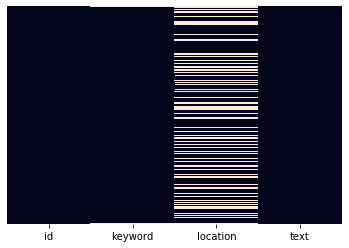

In [21]:
#Let's define a function to explore the missing values for the two datasets
def missing_values(df):
    print('{}% of location values are missing from Total Number of Records.'.format(round((df.location.isnull().sum())/(df.shape[0])*100),2))
    print('{}% of keywords values are missing from Total Number of Records.'.format(round((df.keyword.isnull().sum())/(df.shape[0])*100),2))
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
    null_feat = pd.DataFrame(len(df['id']) - df.isnull().sum(), columns = ['Count'])

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey', line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values")
                    
    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

missing_values(df_train)
missing_values(df_test)

print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')
